---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import typing as tp
import einops

from jaxsw._src.domain.base import Domain
from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg_louis as F_louis
from jaxsw._src.models import qg_ml as F_qgml

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from jaxsw._src.operators.functional import interp as F_interp

In [3]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i], cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_1'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1),[Thiry et al., 2023](https://egusphere.copernicus.org/preprints/2023/egusphere-2023-1715/)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

$$
\begin{aligned}
\Omega_\psi &\in[N_x,N_y] && && [x_0,y_0] && && [x_1,y_1] \\ 
\Omega_u &\in[N_x,N_y+1] && && [x_0,y_0-\frac{1}{2}dy] && && [x_1,y_1+\frac{1}{2}dy]  \\ 
\Omega_v &\in[N_x+1,N_y] && && [x_0-\frac{1}{2}dx,y_0] && && [x_1+\frac{1}{2}dx,y_1]  \\ 
\Omega_q &\in[N_x-1,N_y-1] && && [x_0+\frac{1}{2}dx,y_0+\frac{1}{2}dy] && && [x_1-\frac{1}{2}dx,y_1-\frac{1}{2}dy] 
\end{aligned}
$$

## Parameters

In [4]:
F_qgml.PDEParams??

Init signature: F_qgml.PDEParams(*args, **kwargs)
Docstring:      PDEParams(*args, **kwargs)
Source:        
class PDEParams(eqx.Module):
    f0: float = 9.375e-5  # coriolis [s^-1]
    beta: float = 1.754e-11  # coriolis gradient [m^-1 s^-1]
    tau0: float = 2.0e-5  # wind stress magnitude m/s^2
    y0: float = 2_400_000.0  # [m]
    a_2: float = 0.0  # laplacian diffusion coef (m^2/s)
    a_4: float = 5.0e11  # LR # 2.0e9 # HR
    bcco: float = 0.2  # boundary condition coef. (non-dim.)
    delta_ek: float = 2.0  # eckman height [m]

    @property
    def zfbc(self):
        return self.bcco / (1.0 + 0.5 * self.bcco)
File:           ~/code_projects/jaxsw/jaxsw/_src/models/qg_ml.py
Type:           _ModuleMeta
Subclasses:     

In [5]:
a_4 = 5.0e11  # 2.0e9 #
params = F_qgml.PDEParams()

## Domain

In [6]:
import jaxsw._src.domain.base_v2 as Domain

In [7]:
# Low Resolution
Nx, Ny = 97, 121
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

x_domain = Domain.init_domain_1d(Lx, Nx)
y_domain = Domain.init_domain_1d(Ly, Ny)
x_domain, y_domain
xy_domain = x_domain * y_domain


In [8]:
def check_field_shapes(u: Array, name: str="psi"):

    shape = np.array(u).shape[-2:]
    if name == "psi":
        assert shape == (Nx, Ny)
    elif name == "psi_i":
        assert shape == (Nx-2,Ny-2)
    elif name == "u":
        assert shape == (Nx,Ny-1)
    elif name == "v":
        assert shape == (Nx-1,Ny)
    elif name == "q":
        assert shape == (Nx-1,Ny-1)
    else:
        raise ValueError(f"Unreocngized field: {name}")
        

In [9]:
check_field_shapes(xy_domain.grid_axis[0], name="psi")
check_field_shapes(xy_domain.grid_axis[1], name="psi")

In [10]:
xy_domain.dx, xy_domain.Nx, xy_domain.Lx, xy_domain.cell_volume, xy_domain.ndim

((0.010416666666666666, 0.008333333333333333),
 (97, 121),
 (5120000.0, 5120000.0),
 8.680555555555555e-05,
 2)

### Heights


Remember equation [](#eq:qg_A)

In [11]:
from jaxsw._src.domain.qg import create_qg_multilayer_mat, LayerDomain
# LayerDomain??
create_qg_multilayer_mat??

Signature:
create_qg_multilayer_mat(
    heights: List[float],
    reduced_gravities: List[float],
) -> numpy.ndarray
Source:   
def create_qg_multilayer_mat(
    heights: tp.List[float], reduced_gravities: tp.List[float]
) -> np.ndarray:
    """Computes the Matrix that is used to connected a stacked
    isopycnal Quasi-Geostrophic model.

    Args:
        heights (tp.List[float]): the height for each layer
            Size = [Nx]
        reduced_gravities (tp.List[float]): the reduced gravities
            for each layer, Size = [Nx-1]

    Returns:
        np.ndarray: The Matrix connecting the layers, Size = [Nz, Nx]
    """
    num_heights = len(heights)

    # initialize matrix
    A = np.zeros((num_heights, num_heights))

    if num_heights == 1:
        A[0, 0] = 1. / (heights[0] * reduced_gravities[0])
    else:
        # top rows
        A[0, 0] = 1.0 / (heights[0] * reduced_gravities[0])
        A[0, 1] = -1.0 / (heights[0] * reduced_gravities[0])
    
        # interior rows

In [12]:

# heights
heights = [350.0, 750.0, 2900.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

layer_domain = LayerDomain(heights, reduced_gravities)
layer_domain

LayerDomain(
  heights=f64[3],
  reduced_gravities=f64[2],
  Nz=3,
  A=f64[3,3],
  A_layer_2_mode=f64[3,3],
  A_mode_2_layer=f64[3,3],
  lambda_sq=f64[3]
)

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz Operator}:=\left(\alpha\boldsymbol{\nabla}^2-\beta\right)u
$$

where

$$
\begin{aligned}
u &= \psi \\
\alpha &= 1.0 \\
\beta &= f_0^2\lambda^2
\end{aligned}
$$

In [13]:
# from jaxsw._src.operators.functional import elliptical as F_elliptical
from jaxsw._src.operators.functional.dst import helmholtz_dst, laplacian_dst, inverse_elliptic_dst

In [14]:
L_mat = laplacian_dst(xy_domain.Nx[0]-2, xy_domain.Nx[1]-2, xy_domain.dx[0], xy_domain.dx[1])
check_field_shapes(L_mat, name="psi_i")

In [15]:
lambda_sq = einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")
beta = params.f0**2 * lambda_sq
H_mat = L_mat - beta
H_mat.shape

(3, 95, 119)

In [16]:
check_field_shapes(H_mat, name="psi_i")

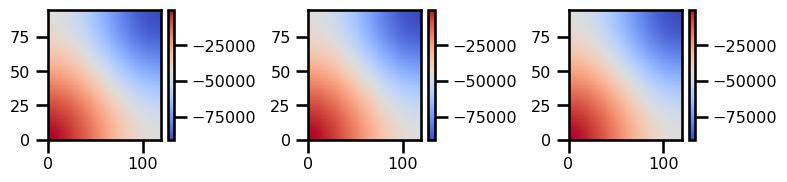

In [17]:
plot_field(H_mat)

### Inversion

We are interested in solving for the Helmholtz equation which is given by

$$
(\boldsymbol{\alpha\nabla}_H^2 - \boldsymbol{\beta})p = q
$$

#### Homogeneous Solution

First, we need to use the scheme to solve the homogeneous Helmholtz equation for the baroclinic nodes.
The homoegeneous equation is given by:

$$
(\boldsymbol{\nabla}_H^2 - \boldsymbol{\beta})p = 0
$$

Let's reformulate the pressure to be:

$$
p = \mathbf{L} + \beta s
$$

where $\mathbf{L}$ is a known solution of the Laplace's equation with non-zero boundaries.

$$
\begin{aligned}
\boldsymbol{\nabla}_H^2\mathbf{L} &= 0 && && x\in\Omega\\
\boldsymbol{F}_{BC}(\mathbf{L}) &= b && && x\in\partial\Omega\\
\end{aligned}
$$

 which is non


In [18]:
# def helmholtz_homogeneous_sol_multilayer(helmoltz_dst_mat, heights, domain):
#     num_layers = len(heights)
#     assert len(helmoltz_dst_mat.shape) == 3

#     # inversion scheme (interior points)
#     # (nabla_H - beta) s = L
#     # constant field (where did we get this???)
#     constant_field = jnp.ones((num_layers, domain.Nx[0], domain.Nx[1])) / (
#         domain.Nx[0] * domain.Nx[1]
#     )

#     out = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0, 0))(
#         constant_field[:, 1:-1, 1:-1], helmoltz_dst_mat
#     )

#     # construct s (interior points)
#     s_solutions = jnp.zeros_like(constant_field)
#     s_solutions = s_solutions.at[:, 1:-1, 1:-1].set(out)

#     # add the boundary: p = L + beta * s
#     beta = einops.repeat(heights, "Nz -> Nz 1 1")
#     homogeneous_sol = constant_field + beta * s_solutions

#     # ignore last solution correponding to lambd = 0, i.e. Laplace equation
#     return homogeneous_sol[:-1]

In [19]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) +xy_domain.Nx)

In [20]:
constant_field = jnp.ones_like(psi0)

sol = jax.vmap(inverse_elliptic_dst, in_axes=(0,0))(constant_field[:, 1:-1,1:-1], H_mat)
sol.shape, constant_field[0, 1:-1,1:-1].shape, H_mat.shape

((3, 97, 121), (95, 119), (3, 95, 119))

In [21]:
homsol = constant_field + sol * lambda_sq
# # NOTE!!!! multiply by masks of Q!!!

In [22]:
check_field_shapes(homsol, name="psi")

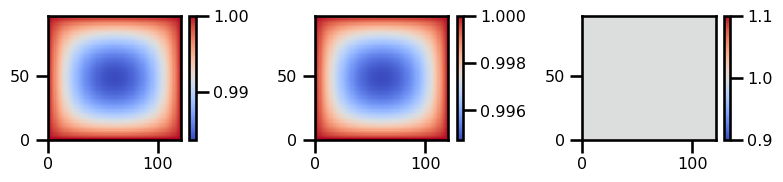

In [23]:
plot_field(homsol)

In [24]:
from jaxsw._src.operators.functional.finitevol.interp import x_average_2D, y_average_2D, center_average_2D

In [25]:
homsol_mean = einops.reduce(center_average_2D(homsol), "Nz Nx Ny -> Nz 1 1", reduction="mean")


## Forcing

## RHS

$$
\begin{aligned}
\text{Advection}: && 
\boldsymbol{D_1} &= 
-\frac{1}{f_0}\boldsymbol{J}(q,p)\\
\text{Diffusion}: && 
\boldsymbol{D_2} &= 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi\\
\text{HyperDiffusion}: && 
\boldsymbol{D_2} &= 
-\frac{a_4}{f_0}\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

#### Advection Term

$$
\boldsymbol{D_1} = 
-\frac{1}{f_0}\boldsymbol{J}(q,p)
$$

Here, we will use the (determinant) Jacobian to calculate this.

In [26]:
from jaxsw._src.operators.functional.finitevol.difference import gradient_perpendicular, laplacian

In [27]:
u, v = jax.vmap(gradient_perpendicular, in_axes=(0,None,None), out_axes=(0,0))(psi0, *xy_domain.dx)
check_field_shapes(u, name="u")
check_field_shapes(v, name="v")

### Potential Vorticity

$$
q = \nabla^2\psi - f_0^2 A\psi + \beta (y-y_0)
$$

In [28]:
# calculate laplacian [Nx,Ny] --> [Nx-2, Ny-2]
psi_lap = jax.vmap(laplacian, in_axes=(0,None))(psi0, xy_domain.dx)
#padding
check_field_shapes(psi_lap, name="psi_i")

psi_lap = jnp.pad(psi_lap, pad_width=((0,0),(1,1),(1,1)), mode="constant", constant_values=0.0)


check_field_shapes(psi_lap, name="psi")

In [29]:
beta_lap = params.f0**2 * jnp.einsum("lm,...mxy->...lxy", layer_domain.A, psi0)

check_field_shapes(beta_lap, name="psi")

In [30]:
from jaxsw._src.operators.functional.interp.flux import tracer_flux

In [31]:
f_y = params.beta * (xy_domain.grid_axis[1] - params.y0)

In [32]:
q = center_average_2D(psi_lap - beta_lap + f_y)
# # NOTE!!!! multiply by masks of Q!!!
check_field_shapes(q, name="q")

## Fluxes

$$
\nabla \cdot (\vec{u}q) = \partial_x (uq) + \partial_y (vq)
$$

In [33]:
u.shape, u[:, 1:-1].shape, q.shape

((3, 97, 120), (3, 95, 120), (3, 96, 120))

**Tracer Flux**

$$
(uq) && | && (vq)
$$

In [34]:
q_flux_on_u = tracer_flux(q, u[:, 1:-1], dim=1, num_pts=1)

q_flux_on_u = jnp.pad(q_flux_on_u, pad_width=((0,0),(1,1),(0,0)))

check_field_shapes(q_flux_on_u, name="u")

In [35]:
q_flux_on_v = tracer_flux(q, v[..., 1:-1], dim=2, num_pts=1)

q_flux_on_v = jnp.pad(q_flux_on_v, pad_width=((0,0),(0,0),(1,1)))

check_field_shapes(q_flux_on_v, name="v")

**Differentiation**

$$
\partial_x (uq) && | && \partial_y (vq)
$$

In [36]:
dq_flux_dx = jnp.diff(q_flux_on_u, n=1, axis=-2) / xy_domain.dx[0]
dq_flux_dy = jnp.diff(q_flux_on_v, n=1, axis=-1) / xy_domain.dx[1]


check_field_shapes(dq_flux_dx, name="q")
check_field_shapes(dq_flux_dy, name="q")

In [37]:
div_flux = dq_flux_dx + dq_flux_dy
check_field_shapes(div_flux, name="q")

* Flux 3 point Stencil
* Bottom Drag
* Solve Helmholtz
* Add Homogeneous Sol
* Boundaries

### Forcings

#### Bottom Drag

$$
\begin{aligned}
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

In [38]:
# interior, vertex points on psi
omega = jax.vmap(laplacian, in_axes=(0,None))(psi0, xy_domain.dx)

check_field_shapes(omega, name="psi_i")

# interior, center points on q
omega = center_average_2D(omega)

# center points on q
# NOTE!!!! multiply by masks of PSI!!!
omega = jnp.pad(omega, pad_width=((0,0),(1,1),(1,1)), mode="constant", constant_values=0.0)

check_field_shapes(omega, name="q")

# bottom drag
bottom_drag_coeff = params.delta_ek / layer_domain.heights[-1] * params.f0 / 2
bottom_drag = - bottom_drag_coeff * omega[-1]

check_field_shapes(bottom_drag, name="q")

#### Forcing


$$
\begin{aligned}
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]
\end{aligned}
$$

In [39]:
# y_coords = xy_domain.grid_axis[1]
# tau0 = 0.08 / 1_000
# curl_tau = - tau0 * 2. * jnp.pi/xy_domain.Lx[1] * jnp.sin(2.0 * jnp.pi * y_coords/xy_domain.Lx[1])

# curl_tau = center_average_2D(curl_tau)
# wind_forcing = curl_tau / layer_domain.heights[0]
# check_field_shapes(wind_forcing, name="q")

In [40]:
y_coords = xy_domain.grid_axis[1]
y_coords_center = center_average_2D(y_coords)
tau0 = 0.08 / 1_000
curl_tau = - tau0 * 2. * jnp.pi/xy_domain.Lx[1] * jnp.sin(2.0 * jnp.pi * y_coords_center/xy_domain.Lx[1])

wind_forcing = curl_tau / layer_domain.heights[0]
check_field_shapes(wind_forcing, name="q")

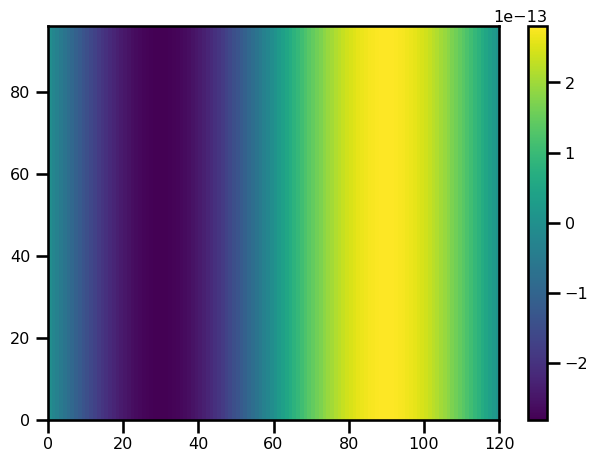

In [41]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(wind_forcing)
plt.colorbar(pts)

plt.tight_layout()
plt.show()

#### Total Forces

In [42]:
forces = jnp.zeros_like(q)

In [43]:
forces = forces.at[0].set(forces[0] + wind_forcing)
forces = forces.at[-1].set(forces[-1] + bottom_drag)

check_field_shapes(forces, name="q")

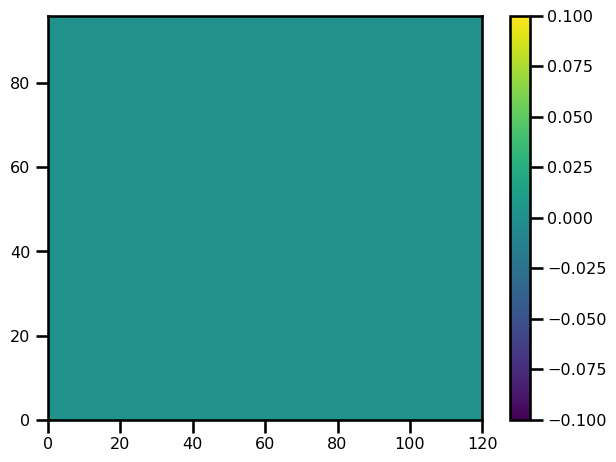

In [44]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(forces[-1])
plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Equation of Motion (RHS)

In [45]:
# NOTE!!!! multiply by masks of Q!!!
adv_rhs = - div_flux + forces

check_field_shapes(adv_rhs, name="q")

## Time Derivatives

In [46]:
# advection RHS --> q
# q interior
# CL2m stuffs
# solve helmholtz elliptical stuffs
# mass convservation Stuff

In [47]:
dq = adv_rhs.copy()

In [48]:
dq_i = center_average_2D(dq)

In [49]:
helmholtz_rhs = jnp.einsum("lm,...mxy->...lxy", layer_domain.A_layer_2_mode, dq_i)

check_field_shapes(helmholtz_rhs, name="psi_i")

**Inverse Solve Elliptical**

In [50]:
check_field_shapes(H_mat, name="psi_i")

In [51]:
dq.shape, dq_i.shape, H_mat.shape, helmholtz_rhs.shape

((3, 96, 120), (3, 95, 119), (3, 95, 119), (3, 95, 119))

In [52]:
dpsi_modes = jax.vmap(inverse_elliptic_dst, in_axes=(0,0))(helmholtz_rhs, H_mat)
check_field_shapes(dpsi_modes, name="psi")

In [53]:
# Add homogeneous solutions to ensure mass conservation

In [54]:
dpsi_modes_i = center_average_2D(dpsi_modes)

alpha = - einops.reduce(dpsi_modes_i, "... Nx Ny -> ... 1 1", reduction="mean") / homsol_mean

dpsi_modes += alpha * homsol

check_field_shapes(dpsi_modes, name="psi")

In [55]:
dpsi = jnp.einsum("LM,...MXY->LXY",layer_domain.A_mode_2_layer, dpsi_modes)
check_field_shapes(dpsi, name="psi")